In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import cartopy.crs as ccrs

### Read data
- ocean mass data
- topographic data

In [4]:
omass=xr.open_dataset("./data/jpl_mascon_ocean-slf.nc")
omass_reg=xr.open_dataset("./data/jpl_mascon_ocean-slf.reg.nc")
topo=xr.open_dataset("./data/topo_interp.nc")

In [5]:
omass

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 139)
Coordinates:
  * time     (time) datetime64[ns] 2002-04-15 2002-05-15 2002-08-15 ...
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75 ...
Data variables:
    z        (time, lat, lon) float64 ...

In [6]:
topo=topo.drop(['x','y'])

In [7]:
topo

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720)
Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75 ...
Data variables:
    z        (lat, lon) float64 ...


---
### Plot the data along the latitudinal line
The variable `sel_lat`  determine the latitude one wants to plot along

#### Lat along $75.25^\circ N$

/usr/local/lib/python2.7/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


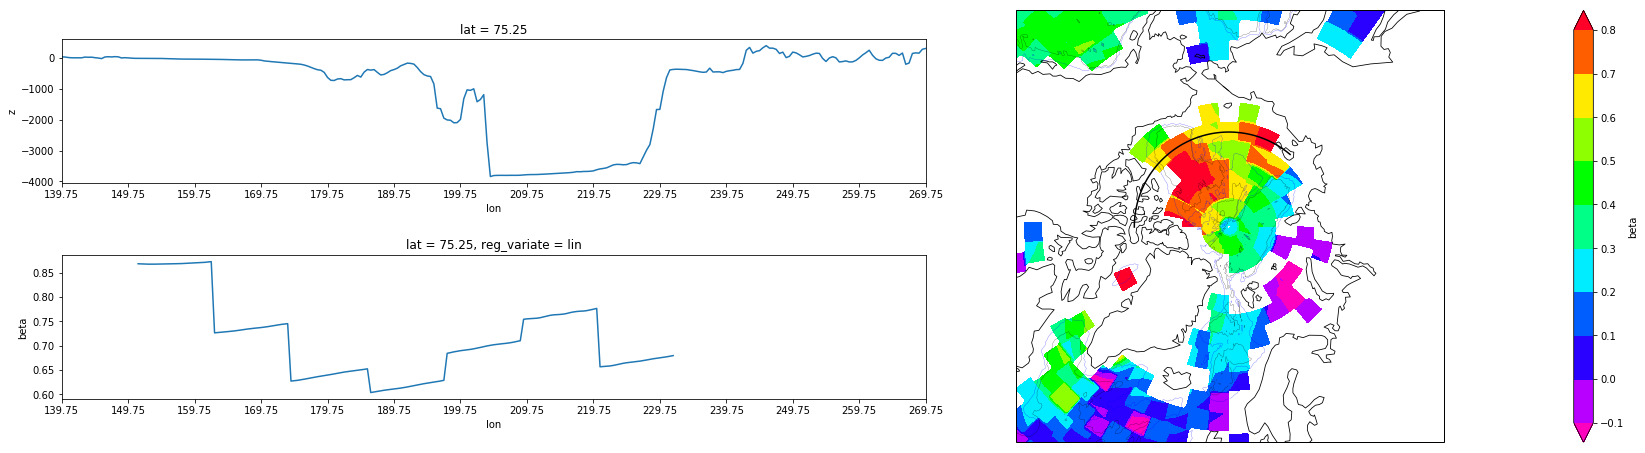

In [8]:
sel_lat=75.25
sel_lon_range= np.arange(140-0.25,270+0.75,0.5)
lon_tick=np.arange(140-0.25,270+0.75,10)

fig=plt.figure(figsize=[12,2])
ax1=fig.add_axes([1,0,1,1])
ax2=fig.add_axes([1,-1.5,1,1])
subplot1=topo['z'].sel({'lat': sel_lat,'lon':sel_lon_range})\
.plot.line(ax=ax1)
subplot2=omass_reg['beta'].sel({'lat': sel_lat,'lon':sel_lon_range,'reg_variate':'lin'})\
.plot.line(ax=ax2)
# set the two axis to be the same
xticklabel=['%0.2f'%(xtick) for xtick in lon_tick ]
ax1.set_xticks(lon_tick)
ax1.set_xbound(lon_tick[0],lon_tick[-1])
ax1.set_xticklabels(xticklabel)
ax2.set_xticks(lon_tick)
ax2.set_xbound(lon_tick[0],lon_tick[-1])
ax2.set_xticklabels(xticklabel)

# set the figure and data projection
data_proj=ccrs.PlateCarree()
fig_proj=ccrs.NorthPolarStereo(0, 90)   
ax3=fig.add_axes([0.2,-1.8,3,3],projection=fig_proj)
# plot the data in each axes
levels=np.linspace(-0.1,0.8,10)
plot1=omass_reg.beta.sel(reg_variate='lin').plot.contourf(ax=ax3, transform=data_proj
        , levels=levels,cmap='gist_rainbow_r')
topo.z.plot.contour(ax=ax3, transform=data_proj
                            , colors='k', levels=[-3000],linewidths=0.2,linestyles='solid')
topo.z.plot.contour(ax=ax3, transform=data_proj
                            , colors='b', levels=[-2000],linewidths=0.2,linestyles='solid')
linlat,linlon=np.meshgrid(sel_lat,sel_lon_range)
ax3.plot(linlon,linlat,'k-',transform=data_proj)
ax3.set_extent([-180,180,57,90], crs=data_proj)
ax3.coastlines(resolution='110m',linewidths=0.8)


---
### Calculate the layer transport 

This part uses my method of calculating the meridional geostrophic volumn transport to compare with the result in [Landerer et al., [2015]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015GL065730)

The geostrophic transport in a certain depth range is calculated based on [Bingham and Hughes [2008]](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2007JC004679)

$$ T_{12}=\frac{1}{f \rho_0}\int^{z2}_{z1}P_E(z) - P_W(z) \text{ dz}$$

which means a layer transport in a certain depth range can be calculated by the pressure differences at the two sides of the basin where $P_E$ and $P_W$ indicate the ocean bottom pressure along the continental slope on eastern and western side of the basin.

In [35]:
#### define constant 
g=9.81                                    # m/s^2
omega=7.292115090e-5                      # rad/s
rho0=1027                                 # kg/m^3 sea water
rhow=1000                                 # kg/m^3 water
f=2.*omega*np.sin(topo.lat/180.*np.pi)    # Coriolis parameter at different latitude

######  setting for the boundary ######
# 75.25 N
z1=-1000
z2=-4000
dx=0.5
sel_lat=75.25
sel_lon_range_west=np.arange(202-0.25,209+0.75,0.5)
sel_lon_range_east=np.arange(219-0.25,245+0.75,0.5)
#######################################


In [36]:
#### define xarray for the latitude band 
topo_east=topo.z.where(topo.lon>0.75,drop=True).values
topo_west=topo.z.where(topo.lon<359.25,drop=True).values
edge025=(topo.z.where(topo.lon==0.75,drop=True).values
        -topo.z.where(topo.lon==0.25,drop=True).values)*2.
edge35975=(topo.z.where(topo.lon==359.75,drop=True).values
        -topo.z.where(topo.lon==359.25,drop=True).values)*2.
coord_lon=topo.lon[1:-1].values
coord_lat=topo.lat.values


#### Calculate the dz for the entire matrix
---
dz is based on central difference for higher order accuracy

$$dz(x_i)=\frac{z(x_{i+1})-z(x_{i-1})}{2}$$

where $x_{i+1}$ is the point east of $x_i$ and $x_{i-1}$ is the point west of $x_i$

In [37]:
#### dz => east - west
dz_ew=xr.DataArray(np.zeros([len(topo.lat.values),len(topo.lon.values)])
                   , coords=[topo.lat.values,topo.lon.values]
                   , dims=['lat','lon'])

dz_ew.loc[coord_lat, coord_lon]=(topo_east-topo_west)/2.
dz_ew.loc[coord_lat, 0.25]=edge025.reshape(len(coord_lat))
dz_ew.loc[coord_lat, 359.75]=edge35975.reshape(len(coord_lat))
coord_lat=None
coord_lon=None
topo_east=None
topo_west=None
edge025=None
edge35975=None

#### Deal with the boundary value of dz when depth range is given
---
To allowed the determination of volumn transport over a certain depth range, the $dz$ value which located right next to the boundary limit (depth range) need to be modify. EX: if one of the depth range limit is between $z(x_i)$ and $z(x_{i+1})$, the dz will need to be modifed to satisfied the set depth range. 

dz$(x_{i+1})$ will be   
$$\text{dz}(x_{i+1})=\frac{z(x_{i+2})-z(x_{i+1})}{2}+z(x_{i+1})-z(x_{zlimit})$$

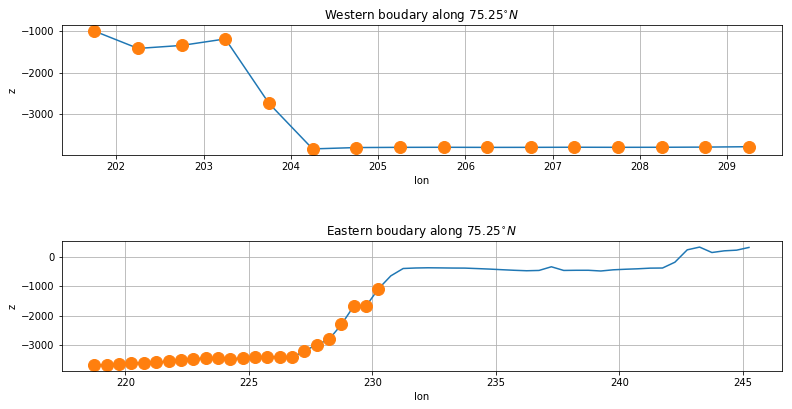

In [38]:
#### dealing the upper boundary and lower boundary dz 
# since dz is now the differences between east and west grids
# if either of the point is located out of the depth range the 
# dz should use upper/low boundary to replace the out of range depth
temp=topo.z.where(topo.z>z2)
topo_z1_z2=temp.where(temp<z1)
temp=None
dz_ew_z1_z2=dz_ew.where(topo_z1_z2.notnull())



# zoom to local region west boundary
topo_loc=topo_z1_z2.sel(lat=sel_lat,lon=sel_lon_range_west)         # slice "topo" in x,y range 
lon_loc_w=topo_loc.where(topo_loc.notnull(),drop=True).lon.values   # slice "lon" in topo range
dz_ew_loc_w=dz_ew_z1_z2.sel(lat=sel_lat,lon=sel_lon_range_west)     # slice "dz" in x,y range 

# modify the two boundary dz
dz_ew_loc_w.loc[lon_loc_w[0]]=(topo_loc.loc[lon_loc_w[1]]-topo_loc.loc[lon_loc_w[0]])/2.\
                          +(topo_loc.loc[lon_loc_w[0]]-z1)
dz_ew_loc_w.loc[lon_loc_w[-1]]=(topo_loc.loc[lon_loc_w[-1]]-topo_loc.loc[lon_loc_w[-2]])/2.\
                          +(z2-topo_loc.loc[lon_loc_w[-1]])

# determine whether the slice lon are continuous
indw=np.append(np.where(np.diff(lon_loc_w)==dx)[0],np.where(np.diff(lon_loc_w)==dx)[0][-1]+1)
if np.sum(np.diff(indw))!= len(indw)-1:
    print "The point along the western slope is not a continous array!!!!"
    print "==> choose the new lon range at the boundary"
    print "    current lon array within the depth range are"
    print "    ", lon_loc_w[indw]


# zoom to local region east boundary
topo_loc=topo_z1_z2.sel(lat=sel_lat,lon=sel_lon_range_east)
lon_loc_e=topo_loc.where(topo_loc.notnull(),drop=True).lon.values
dz_ew_loc_e=dz_ew_z1_z2.sel(lat=sel_lat,lon=sel_lon_range_east)

# modify the two boundary dz
dz_ew_loc_e.loc[lon_loc_e[0]]=(topo_loc.loc[lon_loc_e[1]]-topo_loc.loc[lon_loc_e[0]])/2.\
                          +(topo_loc.loc[lon_loc_e[0]]-z2)
dz_ew_loc_e.loc[lon_loc_e[-1]]=(topo_loc.loc[lon_loc_e[-1]]-topo_loc.loc[lon_loc_e[-2]])/2.\
                          +(z1-topo_loc.loc[lon_loc_e[-1]])

# determine whether the slice lon are continuous
inde=np.append(np.where(np.diff(lon_loc_e)==dx)[0],np.where(np.diff(lon_loc_e)==dx)[0][-1]+1)
if np.sum(np.diff(inde))!= len(inde)-1:
    print "The point along the eastern slope is not a continous array!!!!"
    print "==> choose the new lon range at the boundary"
    print "    current lon array within the depth range are"
    print "    ", lon_loc_e[inde]


#### plot the location of the west and east boundary
fig=plt.figure(figsize=[10,3])
ax1=fig.add_axes([0,0,1,0.6])
ax2=fig.add_axes([0,-1,1,0.6])
plot1=topo.z.sel(lat=sel_lat,lon=sel_lon_range_west).plot(ax=ax1)
point1=topo.z.sel(lat=sel_lat,lon=lon_loc_w[indw]).plot(ax=ax1
        ,color='#ff7f0e', marker='o', linestyle='none',markersize=12)
plot2=topo.z.sel(lat=sel_lat,lon=sel_lon_range_east).plot(ax=ax2)
point2=topo.z.sel(lat=sel_lat,lon=lon_loc_e[inde]).plot(ax=ax2
        ,color='#ff7f0e', marker='o', linestyle='none',markersize=12)
ax1.grid()
ax2.grid()
ax1.set_title('Western boudary along %0.2f$^{\circ}N$'%sel_lat)
ax2.set_title('Eastern boudary along %0.2f$^{\circ}N$'%sel_lat)

#### Calculate the integration
---
The derivation below is based on two equation. 

* One is the relation between pressure ($\text{dP}$) and the water equivalent height($\text{dH}$), which GRACE observed 

> $$ \text{dP} = \text{dH}\times(\rho_w g)  $$
> $$ \text{dP} \text{dz}= \text{dH}\text{dz}\times(\rho_w g)  $$
> where $\rho_w$ is the pure water density and $g$ is the gravitational acceleration. 

* The other is the geostrophic balance in the meridional direction

> $$ \frac{1}{\rho_0}\frac{\partial P}{\partial x} = fv $$
> where $f$ is the Coriolis parameter, $\rho_0$ is the sea water average density. This equation can be further written as 
>
> $$ v\text{dx} = \frac{1}{\rho_o f}\text{dP}$$
>
> $$ v\text{dx} \text{dz} = \frac{1}{\rho_o f}\text{dP}\text{dz}$$
>
> $$ V = \frac{\rho_w g}{\rho_o f}\text{dH}\text{dz}$$
>
> where we define $V = v\text{ dx}\text{ dz}$ as the meridional (volumn) transport (with unit of Sv)


In [39]:
omass_dz_w=omass.z.sel(lat=sel_lat)*0.01*-(dz_ew_loc_w.sel(lon=lon_loc_w[indw])) # h*-(dz_ew) = cm * 0.01 * m 
omass_dz_e=omass.z.sel(lat=sel_lat)*0.01*(dz_ew_loc_e.sel(lon=lon_loc_e[inde]))  # h*(dz_ew)  = cm * 0.01 * m
int_w=omass_dz_w.sum(dim='lon',skipna=True)    # sum(h*dz) 
int_e=omass_dz_e.sum(dim='lon',skipna=True)    # sum(h*dz)
meridN_w=-int_w*rhow*g/f.sel(lat=sel_lat)/rho0*1e-6 # m^2 * kg/m^3 * m/s^2 / (1/s) / (kg/m^3) *1E-6 = m^3/s * Sv/m^3 = Sv
meridN_e=int_e*rhow*g/f.sel(lat=sel_lat)/rho0*1e-6  # m^2 * kg/m^3 * m/s^2 / (1/s) / (kg/m^3) *1E-6 = m^3/s * Sv/m^3 = Sv
meridN=meridN_e+meridN_w

---
### Regression to remove linear trend/ linear trend + seasonal + semiseasonal

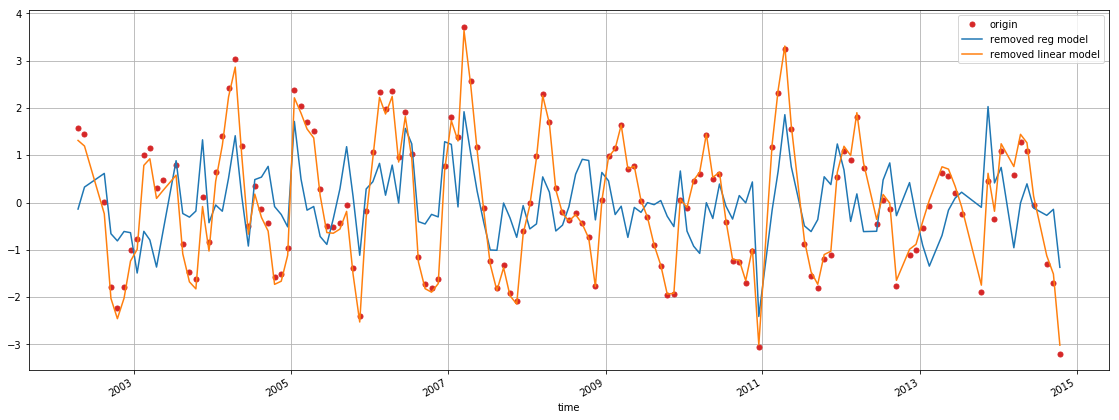

In [46]:
from time_convert import time_convert
ts=time_convert(meridN.time)
yeardate=ts.tarray_month2year()

from regression import regress
reg=regress(axis=yeardate)
dict1=reg.multivar_regress(meridN.values,predef_var='semisea_sea_lin')
list_variates=dict1['list_variates']
betas=dict1['beta']
linmodel=betas[0]*list_variates[0]+betas[1]*list_variates[1]
model=dict1['model']
res=meridN.values-model
reslin=meridN.values-linmodel
meridN_res=xr.DataArray(res, coords={"time":meridN.time},dims="time")
meridN_reslin=xr.DataArray(reslin, coords={"time":meridN.time},dims="time")

fig=plt.figure(figsize=[10,5])
ax1=fig.add_axes([0,0,1.5,1])
# meridN.plot(ax=ax1)
# meridN_res.plot(ax=ax1)
# meridN_sm.plot(ax=ax1)
meridN.plot(ax=ax1,color='#d62728', marker='o', linestyle='none',markersize=5,label='origin')
meridN_res.plot(ax=ax1,label='removed reg model')
meridN_reslin.plot(ax=ax1,label='removed linear model')

ax1.grid()
ax1.legend()


---
### 13 months smoothing

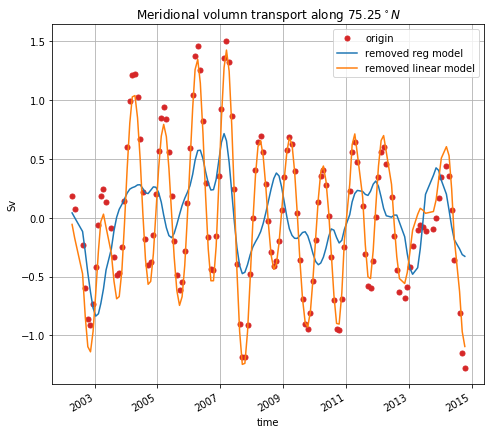

In [48]:
from smooth import smooth_1d

window_len=13
ori=smooth_1d(meridN,window_len=window_len)
meridN_sm=xr.DataArray(ori, coords={"time":meridN.time},dims="time")
smo_res=smooth_1d(meridN_res,window_len=window_len)
meridN_sm_res=xr.DataArray(smo_res, coords={"time":meridN.time},dims="time")
smo_reslin=smooth_1d(meridN_reslin,window_len=window_len)
meridN_sm_reslin=xr.DataArray(smo_reslin, coords={"time":meridN.time},dims="time")

fig=plt.figure(figsize=[4,5])
ax1=fig.add_axes([0,0,1.5,1])
meridN_sm.plot(ax=ax1,color='#d62728', marker='o', linestyle='none',markersize=5,label='origin')
meridN_sm_res.plot(ax=ax1,label='removed reg model')
meridN_sm_reslin.plot(ax=ax1,label='removed linear model')
ax1.grid()
ax1.legend()
ax1.set_ylabel('Sv')
ax1.set_title('Meridional volumn transport along %0.2f$^\circ N$'%(sel_lat))